In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

# Loading the Data

In [24]:
data = pd.read_csv('processed_data/fraud_data_processed.csv', index_col=0)
data.head(2)

,category,amt,gender,lat,long,city_pop,merch_lat,merch_long,is_fraud,customer_age
0,personal_care,2.86,M,33.9659,-80.9355,333497,33.986391,-81.200714,0,52.0
1,personal_care,29.84,F,40.3207,-110.4360,302,39.450498,-109.960431,0,30.0


In [13]:
data.dtypes

category         object
amt             float64
gender           object
lat             float64
long            float64
city_pop          int64
merch_lat       float64
merch_long      float64
is_fraud          int64
customer_age    float64
dtype: object

(array([1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(1, 0, 'amt'),
  Text(2, 0, 'lat'),
  Text(3, 0, 'long'),
  Text(4, 0, 'city_pop'),
  Text(5, 0, 'merch_lat'),
  Text(6, 0, 'merch_long'),
  Text(7, 0, 'is_fraud'),
  Text(8, 0, 'customer_age')])

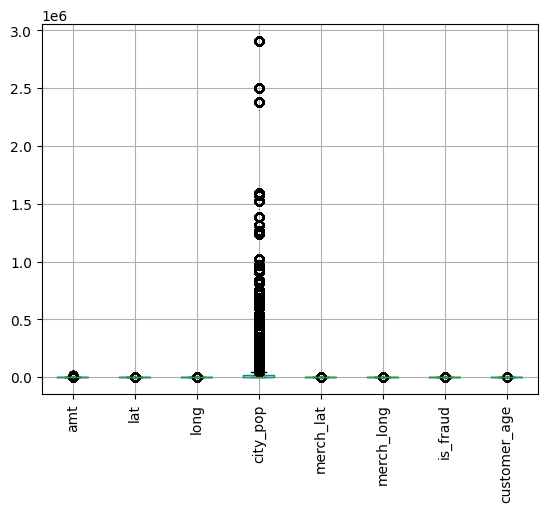

In [14]:
data.boxplot()
plt.xticks(rotation=90)

In [25]:
no_outliers = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'customer_age']

preprocessor = make_column_transformer(
    (RobustScaler(),['city_pop']),
    (MinMaxScaler(), no_outliers),
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=['object'])), remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('robustscaler', RobustScaler(), ['city_pop']),
                                ('minmaxscaler', MinMaxScaler(),
                                 ['amt', 'lat', 'long', 'merch_lat',
                                  'merch_long', 'customer_age']),
                                ('onehotencoder',
                                 OneHotEncoder(sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x2a01f7610>)])

In [33]:
X = data.drop(columns=['is_fraud'])
y = data['is_fraud']
print(X.shape)
print(y.shape)

(555719, 9)
(555719,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(y_train.shape)

(389003, 9)
(389003,)


In [35]:
X_train_processed = preprocessor.fit_transform(X_train)

In [37]:
X_train_processed[0]

array([1.05360698, 0.01235203, 0.52707456, 0.97657948, 0.54171846,
       0.9692015 , 0.58024691, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        ])

In [38]:
X_test_processed = preprocessor.transform(X_test)

In [39]:
print(type(X_train_processed))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [40]:
print(X_train_processed.shape)
print(y_train.shape)

(389003, 23)
(389003,)


In [41]:
X_train_tensor = torch.tensor(X_train_processed).float()
y_train_tensor = torch.tensor(y_train.to_numpy()).float()

# Modeling

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
# X_train_processed = torch.tensor(X_train_processed).float().to(device)
# y_train_processed = torch.tensor(y_train).float().to(device)

In [43]:
class ModelDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.X = x
        self.y = y

    def __getitem__(self, idx):
        features = self.X[idx]
        labels = self.y[idx]
        return features, labels

    def __len__(self):
        return self.X.shape[0]

In [44]:
training_ds = ModelDataset(X_train_tensor, y_train_tensor)

dataloader_train = DataLoader(training_ds, batch_size=32, shuffle=True)

In [45]:
test_ds = ModelDataset(torch.tensor(X_test_processed).float(), torch.tensor(y_test.to_numpy()).float())

dataloader_test = DataLoader(test_ds, batch_size=32, shuffle=True)

In [46]:
feature, labels = next(iter(dataloader_test))
print(f"Features: {feature}, Labels:{labels}")

Features: tensor([[ 2.6742e-01,  3.0057e-02,  4.6460e-01,  8.5883e-01,  4.7965e-01,
          8.4971e-01,  2.0988e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 1.4480e+00,  3.0061e-03,  4.4640e-01,  9.3566e-01,  4.2899e-01,
          9.2732e-01,  1.4815e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.0000e+00],
        [-1.1594e-01,  1.9067e-03,  4.2500e-01,  8.0087e-01,  4.0859e-01,
          7.9984e-01,  4.6914e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
    

In [52]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(23, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 20)
        self.fc4 = nn.Linear(20, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.sigmoid(self.fc4(x))
        return x

In [53]:
model = NeuralNetwork()

In [54]:
model

NeuralNetwork(
  (fc1): Linear(in_features=23, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)

In [55]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [56]:
for epoch in range(100):
    print(f'Working on epoch:{epoch+1}/100')
    for features, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels.view(-1,1))
        loss.backward()
        optimizer.step()

Working on epoch:1/100
Working on epoch:2/100
Working on epoch:3/100
Working on epoch:4/100
Working on epoch:5/100
Working on epoch:6/100
Working on epoch:7/100
Working on epoch:8/100
Working on epoch:9/100
Working on epoch:10/100
Working on epoch:11/100
Working on epoch:12/100
Working on epoch:13/100
Working on epoch:14/100
Working on epoch:15/100
Working on epoch:16/100
Working on epoch:17/100
Working on epoch:18/100
Working on epoch:19/100
Working on epoch:20/100
Working on epoch:21/100
Working on epoch:22/100
Working on epoch:23/100
Working on epoch:24/100
Working on epoch:25/100
Working on epoch:26/100
Working on epoch:27/100
Working on epoch:28/100
Working on epoch:29/100
Working on epoch:30/100
Working on epoch:31/100
Working on epoch:32/100
Working on epoch:33/100
Working on epoch:34/100
Working on epoch:35/100
Working on epoch:36/100
Working on epoch:37/100
Working on epoch:38/100
Working on epoch:39/100
Working on epoch:40/100
Working on epoch:41/100
Working on epoch:42/100
W

In [57]:
from torchmetrics.classification import BinaryRecall

In [58]:
metric = BinaryRecall()
predictions = []
model.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        outputs = model(features)
        pred = (outputs >= 0.5).float()
        predictions.append(pred)
        metric(pred, labels.view(-1,1))

recall = metric.compute()
print(f'Recall: {recall}')

Recall: 0.0


It looks like this model is unable to idenify any fraudluent transactions.

Let's save the model weights so we can play around the with model more later without retraining.

In [71]:
torch.save(model.state_dict(), 'model_weights/100_epoch_model_weights.pt')